## Computer Aided Gastrointestinal Disease Detection using PyTorch.

In [1]:
import os
import random
import splitfolders
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from typing import Tuple, Dict, List

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [2]:
# Setup device-agnostic code

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
data_folder = r'D:\Miniconda\pytorch\data_folder'
os.listdir(data_folder)

['test', 'train', 'val']

In [4]:
# splitfolders.ratio(input= data_folder, ratio=(0.8, 0.1, 0.1) , move=True)

In [5]:
train_path = data_folder + '\\train\\'
val_path   = data_folder + '\\val\\'
test_path = data_folder + '\\test\\'

print(train_path)
print(val_path)
print(test_path)

D:\Miniconda\pytorch\data_folder\train\
D:\Miniconda\pytorch\data_folder\val\
D:\Miniconda\pytorch\data_folder\test\


In [6]:
os.listdir(train_path)

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

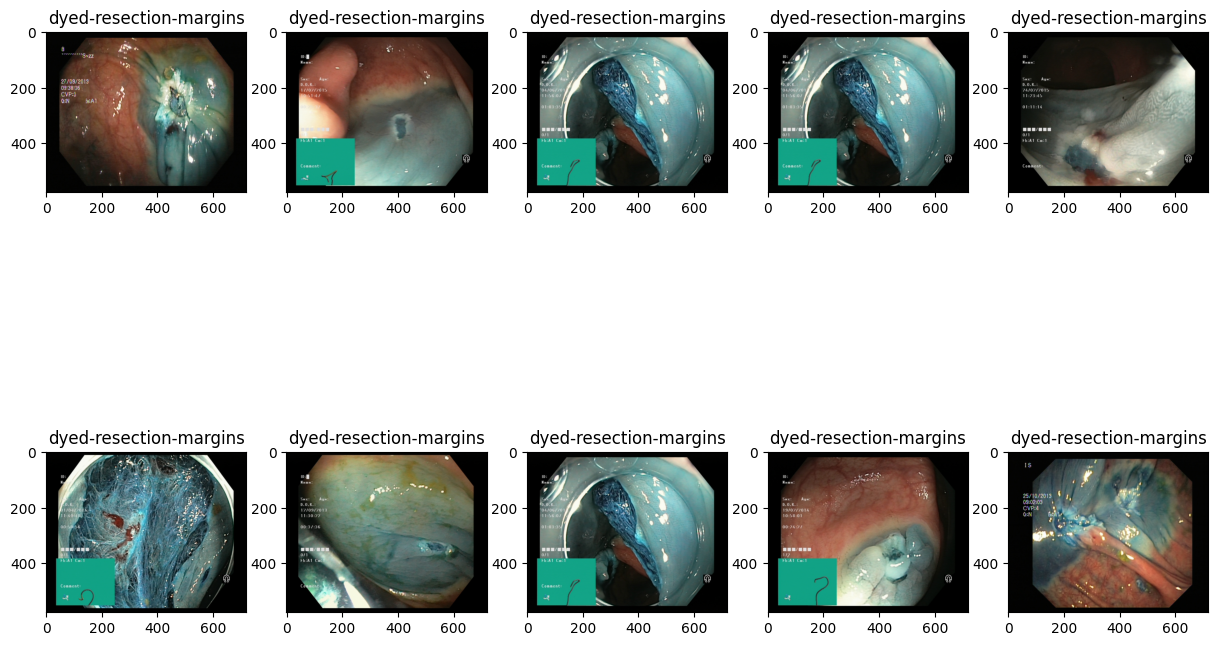

In [7]:
plt.figure(figsize=(15 , 10))

for i in range(5):
    
    test_category =  random.choice(os.listdir(test_path))
    image_path = os.path.join(test_path , test_category)

    for i in range (10):

            file = random.choice(os.listdir(image_path))

            image = os.path.join(image_path , file)

            img = imread(image)

            ax = plt.subplot(2 , 5 , i+1)

            ax.title.set_text(test_category)

            plt.imshow(img)

In [8]:
# Write transform for image
train_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=12), 
                                      transforms.ToTensor()])

valid_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                     transforms.ToTensor()])


train_data = datasets.ImageFolder(train_path, transform= train_transform)
valid_data = datasets.ImageFolder(val_path,   transform= valid_transform)
test_data  = datasets.ImageFolder(test_path,  transform= test_transform)


BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader = DataLoader(train_data, 
                              batch_size= BATCH_SIZE, 
                              shuffle= True,
                              num_workers= NUM_WORKERS)

valid_dataloader = DataLoader(valid_data, 
                              batch_size= BATCH_SIZE, 
                              shuffle= False, 
                              num_workers= NUM_WORKERS)

test_dataloader  = DataLoader(test_data, 
                              batch_size= BATCH_SIZE, 
                              shuffle= False, 
                              num_workers= NUM_WORKERS)


In [9]:
class_names = train_data.classes
class_names

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

In [10]:
class_dict = train_data.class_to_idx
class_dict

{'dyed-lifted-polyps': 0,
 'dyed-resection-margins': 1,
 'esophagitis': 2,
 'normal-cecum': 3,
 'normal-pylorus': 4,
 'normal-z-line': 5,
 'polyps': 6,
 'ulcerative-colitis': 7}

In [11]:
class TinyVGG(nn.Module):
    
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1), 
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units*16*16, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=512, out_features= output_shape))
        
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model = TinyVGG(
        input_shape=3,
        hidden_units=10,
        output_shape=len(train_data.classes)).to(device)


In [12]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [13]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [14]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          valid_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "valid_loss": [],
               "valid_acc": []}

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        
        valid_loss, valid_acc = test_step(model=model,
            dataloader=valid_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"valid_loss: {valid_loss:.4f} | "
            f"valid_acc: {valid_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [15]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=128, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [16]:
from torchinfo import summary
summary(model, input_size=[1, 3, 64, 64]) 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 8]                    --
├─Sequential: 1-1                        [1, 128, 32, 32]          --
│    └─Conv2d: 2-1                       [1, 128, 64, 64]          3,584
│    └─BatchNorm2d: 2-2                  [1, 128, 64, 64]          256
│    └─ReLU: 2-3                         [1, 128, 64, 64]          --
│    └─Conv2d: 2-4                       [1, 128, 64, 64]          147,584
│    └─BatchNorm2d: 2-5                  [1, 128, 64, 64]          256
│    └─ReLU: 2-6                         [1, 128, 64, 64]          --
│    └─MaxPool2d: 2-7                    [1, 128, 32, 32]          --
├─Sequential: 1-2                        [1, 128, 16, 16]          --
│    └─Conv2d: 2-8                       [1, 128, 32, 32]          147,584
│    └─BatchNorm2d: 2-9                  [1, 128, 32, 32]          256
│    └─ReLU: 2-10                        [1, 128, 32, 32]          --

In [17]:
# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train the model
model_results = train(model= model, 
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {(end_time-start_time)/60:.3f} minutes")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7504 | train_acc: 0.3831 | valid_loss: 0.9263 | valid_acc: 0.6082
Epoch: 2 | train_loss: 1.1995 | train_acc: 0.5019 | valid_loss: 0.9744 | valid_acc: 0.5337
Epoch: 3 | train_loss: 1.1025 | train_acc: 0.5278 | valid_loss: 0.8990 | valid_acc: 0.5697
Epoch: 4 | train_loss: 1.0728 | train_acc: 0.5406 | valid_loss: 0.8184 | valid_acc: 0.6058
Epoch: 5 | train_loss: 1.0150 | train_acc: 0.5459 | valid_loss: 0.7364 | valid_acc: 0.6490
Epoch: 6 | train_loss: 1.0120 | train_acc: 0.5503 | valid_loss: 0.7303 | valid_acc: 0.6394
Epoch: 7 | train_loss: 0.9989 | train_acc: 0.5506 | valid_loss: 0.8539 | valid_acc: 0.6130
Epoch: 8 | train_loss: 0.9591 | train_acc: 0.5672 | valid_loss: 0.7272 | valid_acc: 0.6442
Epoch: 9 | train_loss: 0.9744 | train_acc: 0.5603 | valid_loss: 0.8895 | valid_acc: 0.6298
Epoch: 10 | train_loss: 0.9398 | train_acc: 0.5813 | valid_loss: 0.7105 | valid_acc: 0.6635
Epoch: 11 | train_loss: 0.9275 | train_acc: 0.5900 | valid_loss: 0.6977 | valid_acc: 0.67

In [18]:
def plot_loss_curves(results: Dict[str, List[float]]):
    # Get the loss values of the results dictionary (training and valid)
    loss = results['train_loss']
    valid_loss = results['valid_loss']

    # Get the accuracy values of the results dictionary (training and valid)
    accuracy = results['train_acc']
    valid_accuracy = results['valid_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, valid_loss, label='valid_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, valid_accuracy, label='valid_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

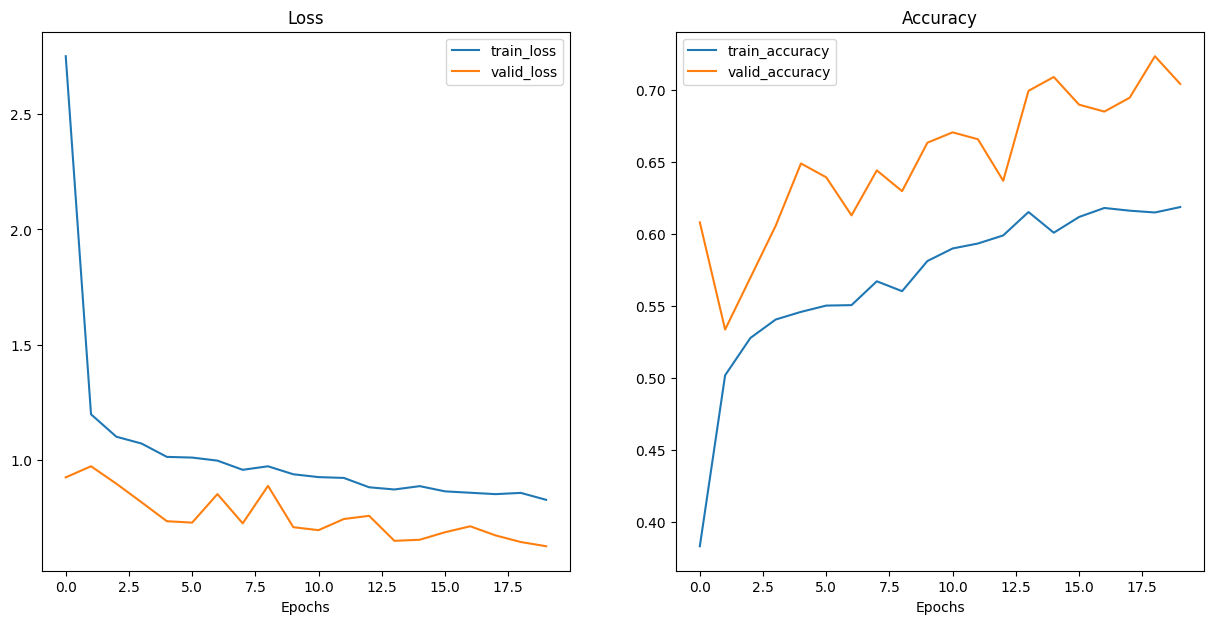

In [19]:
plot_loss_curves(model_results)

In [20]:
# Test the model
model.eval()  

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy of the model on the test images: {100*(correct / total):.2f} %')

Test Accuracy of the model on the test images: 68.75 %
